Data Found at Following Link: https://repository.library.northeastern.edu/files/neu:gm80mp276

#Echo State Network

In [1]:
from reservoirpy.nodes import ScikitLearnNode
from reservoirpy.nodes import Reservoir, Ridge, Input, ESN, NVAR
from reservoirpy.observables import rmse, rsquare
from Processor import  POWDERRF_Processor
from Modeling import RC_Seq_Classifier,  Conv1D_RF_Classifier
from time import perf_counter
import os
import random
import json
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from types import SimpleNamespace

In [2]:

Expieriment_Name = "Protocol_test"

datadir = "GlobecomPOWDER/";
savedir = Expieriment_Name + "/";

if os.path.isdir(savedir) != True:
    os.mkdir(savedir);

print(os.path.isdir(datadir))
print(os.path.isdir(savedir))


True
True


In [3]:
processor = POWDERRF_Processor(datadir = datadir, sample_len = 1024 , samples_per_sig = 10, max_samples = 100, data_days = [1, 2], savedir = savedir)
data_dict = processor.parse_labels(save = True);
xtrain, ytrain, xtest, ytest = processor(train_test_split=.8, signal_type="All", task = "transmitter", loaddatadict = True, normalize = False);

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 305.67it/s]


In [4]:
print(xtrain);
print(ytrain.shape);
print(xtest.shape);
print(ytest.shape);
#processor.get_labeldist();

[[[-8.23999580e-04 -1.15970313e-03 -4.94399713e-03 ...  2.31940625e-03
    3.17392428e-03 -8.85036541e-04]
  [-5.76799689e-03 -4.39466443e-03 -2.31940625e-03 ... -7.01925543e-04
    4.57777525e-04 -4.27259016e-04]
  [ 5.82655674e-03  4.54510581e-03  5.46102124e-03 ...  2.42329215e-03
    3.20676716e-03  9.82771563e-04]
  [ 5.82655674e-03  4.54510581e-03  5.46102124e-03 ...  2.42329215e-03
    3.20676716e-03  9.82771563e-04]]

 [[ 3.66222026e-04  4.57777525e-04 -5.79851563e-04 ...  1.25125854e-03
   -3.05185022e-05 -7.62962562e-04]
  [ 8.85036541e-04 -2.44148029e-03 -1.19022164e-03 ... -9.15555051e-04
   -7.93481071e-04 -7.62962562e-04]
  [ 9.57814310e-04  2.48402622e-03  1.32395445e-03 ...  1.55044799e-03
    7.94067748e-04  1.07899200e-03]
  [ 9.57814310e-04  2.48402622e-03  1.32395445e-03 ...  1.55044799e-03
    7.94067748e-04  1.07899200e-03]]

 [[-9.76592069e-04 -1.49540661e-03  1.22074009e-04 ...  6.40888524e-04
    3.38755385e-03 -2.74666527e-04]
  [-3.96740536e-04  4.88296035e-0

Fourier Analysis of Signals

In [40]:
reservoir_params = {"units": 1024, "lr":0.5, "sr":0.9, "rc_connectivity":0.5}
n_reservoirs = 2
reservoir =  Reservoir(**reservoir_params);
for i in range(n_reservoirs - 1):
    reservoir = reservoir >> Reservoir(**reservoir_params);
classifier = RC_Seq_Classifier(seq_sub_size=256,savedir=savedir ,reservoir = reservoir);
print(reservoir)

'Model-9': Model('Reservoir-19', 'Reservoir-20')


In [41]:
classifier.train = True;
classifier.train_Ridge(xtrain,ytrain, load_laststates=False, savemodel = True);

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:32<00:00, 244.37it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 266.79it/s]


accuracy score: 0.7165


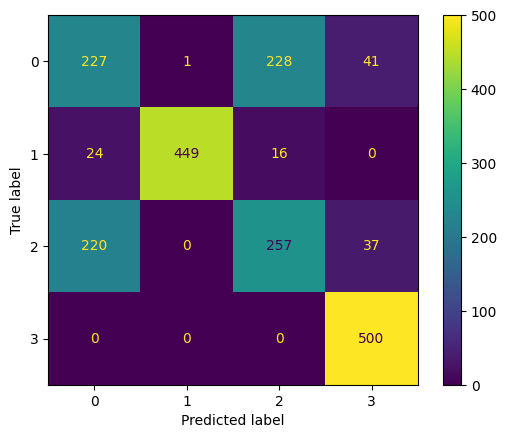

In [42]:
classifier.train = False;
classifier.eval_Ridge(xtest=xtest, ytest=ytest, load_laststates=False);

In [28]:
classifier.get_reservoir_laststate(samples = xtrain, savestates=True);
classifier.Visualize_reservoir_laststate2D(xsamples=xtrain, ysamples=ytrain, label_encoder=processor.label_encoder,load_laststates=True);

 15%|███████████████████████████▊                                                                                                                                                           | 608/4000 [00:27<02:31, 22.44it/s]

KeyboardInterrupt



#Time Series Foundation Models

In [1]:
import pandas as pd
import torch
from chronos import ChronosPipeline
from Processor import  POWDERRF_Processor
from Modeling import RC_Seq_Classifier, Conv1D_RF_Classifier
from time import perf_counter
import os
import random
import json
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from types import SimpleNamespace
from sklearn.manifold import TSNE

/home/tariq/anaconda3/envs/RF_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def get_parameters_count(model_path):
        model = Conv1D_RF_Classifier(classes = 12, seq_len = 1024)
        model_checkpoint = torch.load(model_path);
        model.load_state_dict(model_checkpoint);
        return sum(p.numel() for p in model.parameters());
#model_path = "./results_protocol/final_model.pth";
#model_path = "./results_transmitter/final_model.pth";
model_path = "./results_both/final_model.pth";

N_param = get_parameters_count(model_path);
print(N_param)

524636


/tmp/ipykernel_9106/3679278515.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load(model_path);


In [28]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",
    torch_dtype=torch.float,
)

In [11]:
Expieriment_Name = "ts_foundation_model"

datadir = "GlobecomPOWDER/";
savedir = Expieriment_Name + "/";

if os.path.isdir(savedir) != True:
    os.mkdir(savedir);

print(os.path.isdir(datadir))
print(os.path.isdir(savedir))

processor = POWDERRF_Processor(datadir = datadir, sample_len = 512, samples_per_sig = 10, max_samples = 25000, data_days = [1, 2], savedir = savedir)
#data_dict = processor.parse_labels(save = True);
xtrain, ytrain, xtest, ytest = processor(train_test_split=.8, signal_type="Complex", task = "transmitter", loaddatadict = False);

#df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
#df["#Passengers"]

True
True


100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 82.86it/s]


In [81]:
Train time-series foundation model

SyntaxError: invalid syntax (3808649921.py, line 1)

In [8]:
batch_sz = 100;
epochs = 5000;
i_update = 50;
xtrain_batched = torch.tensor(xtrain)
xtrain_batched = torch.split(xtrain_batched, batch_sz);
ytrain_batched = torch.argmax(torch.tensor(ytrain),dim = -1);
ytrain_batched = torch.split(ytrain_batched, batch_sz);
loss_list = [];
#model = Chronos_RF_Classifier(tokenizer = pipeline.tokenizer, encoder = pipeline.model, device = "cuda:0", classes = 4, hidden_sz = 768)
model = Conv1D_RF_Classifier(classes = 4)
model = model.to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01);
loss_sum = 0;
step = 0;
for epoch in tqdm(range(epochs)):
    print("Epoch:", epoch);
    i = 0;
    for x_batch, y_batch in zip(xtrain_batched, ytrain_batched):
        i += 1;
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        x_batch = x_batch.to('cuda:0');
    
        logits = model(x_batch);
        logits = logits.reshape((-1, logits.shape[1]));
        y_batch = y_batch.flatten().to(model.device);

        # Compute the loss and its gradients
        loss = loss_fn(logits, y_batch)
        loss.backward();
        step += 1;
        loss_sum += loss.item();
        #loss_list.append(loss.item())
        #if i%i_update == 0: print("loss:", loss_sum/step);

        # Adjust learning weights
        optimizer.step();

80it [00:00, 353.47it/s]


loss: 0.4866339022805485
Epoch: 4218


80it [00:00, 353.21it/s]


loss: 0.48662853340664036
Epoch: 4219


80it [00:00, 354.83it/s]


loss: 0.48661781378392976
Epoch: 4220


80it [00:00, 353.06it/s]


loss: 0.4866135822137903
Epoch: 4221


80it [00:00, 352.98it/s]


loss: 0.48660703913959996
Epoch: 4222


80it [00:00, 352.43it/s]


loss: 0.486596891464315
Epoch: 4223


80it [00:00, 353.04it/s]


loss: 0.486586771328586
Epoch: 4224


80it [00:00, 353.41it/s]


loss: 0.48658229047058604
Epoch: 4225


80it [00:00, 353.33it/s]


loss: 0.48657823674139444
Epoch: 4226


80it [00:00, 352.42it/s]


loss: 0.4865681418443877
Epoch: 4227


80it [00:00, 353.83it/s]


loss: 0.486559915761355
Epoch: 4228


80it [00:00, 352.34it/s]


loss: 0.48655895283847933
Epoch: 4229


80it [00:00, 354.65it/s]


loss: 0.48655033518158136
Epoch: 4230


80it [00:00, 353.41it/s]


loss: 0.4865449057663186
Epoch: 4231


80it [00:00, 352.92it/s]


loss: 0.48653999776888524
Epoch: 4232


80it [00:00, 352.78it/s]


loss: 0.4865277953771342
Epoch: 4233


80it [00:00, 352.15it/s]


loss: 0.48651831167565524
Epoch: 4234


80it [00:00, 353.98it/s]


loss: 0.4865085310589821
Epoch: 4235


80it [00:00, 352.70it/s]


loss: 0.4864977049271723
Epoch: 4236


80it [00:00, 352.81it/s]


loss: 0.4864947711714807
Epoch: 4237


80it [00:00, 352.82it/s]


loss: 0.4864875737170984
Epoch: 4238


80it [00:00, 352.68it/s]


loss: 0.4864863941941147
Epoch: 4239


80it [00:00, 353.15it/s]


loss: 0.4864844356921391
Epoch: 4240


80it [00:00, 353.14it/s]


loss: 0.4864798825204416
Epoch: 4241


80it [00:00, 355.02it/s]


loss: 0.4864716807829059
Epoch: 4242


80it [00:00, 351.80it/s]


loss: 0.48646776672231085
Epoch: 4243


80it [00:00, 354.21it/s]


loss: 0.4864605853403804
Epoch: 4244


80it [00:00, 352.70it/s]


loss: 0.48645542583935963
Epoch: 4245


80it [00:00, 353.22it/s]


loss: 0.4864504427571071
Epoch: 4246


80it [00:00, 353.09it/s]


loss: 0.48644288279908077
Epoch: 4247


80it [00:00, 353.08it/s]


loss: 0.48643265929620033
Epoch: 4248


80it [00:00, 353.05it/s]


loss: 0.48642712236590613
Epoch: 4249


80it [00:00, 352.43it/s]


loss: 0.48641980189303985
Epoch: 4250


80it [00:00, 353.01it/s]


loss: 0.48641010667993434
Epoch: 4251


80it [00:00, 352.26it/s]


loss: 0.4863971263193024
Epoch: 4252


80it [00:00, 351.23it/s]


loss: 0.4863907742238294
Epoch: 4253


80it [00:00, 351.90it/s]


loss: 0.4863890527479497
Epoch: 4254


80it [00:00, 352.95it/s]


loss: 0.4863841719890161
Epoch: 4255


80it [00:00, 352.36it/s]


loss: 0.4863817319896344
Epoch: 4256


80it [00:00, 353.07it/s]


loss: 0.4863712936767999
Epoch: 4257


80it [00:00, 351.11it/s]


loss: 0.4863695606463322
Epoch: 4258


80it [00:00, 352.53it/s]


loss: 0.4863652666081628
Epoch: 4259


80it [00:00, 352.90it/s]


loss: 0.4863606879543988
Epoch: 4260


80it [00:00, 352.04it/s]


loss: 0.48635515631840903
Epoch: 4261


80it [00:00, 352.50it/s]


loss: 0.48634812281305384
Epoch: 4262


80it [00:00, 352.23it/s]


loss: 0.48634018161092973
Epoch: 4263


80it [00:00, 352.80it/s]


loss: 0.486332126257235
Epoch: 4264


80it [00:00, 352.58it/s]


loss: 0.4863248856135199
Epoch: 4265


80it [00:00, 352.12it/s]


loss: 0.486314386007681
Epoch: 4266


80it [00:00, 351.91it/s]


loss: 0.4863122671199083
Epoch: 4267


80it [00:00, 352.59it/s]


loss: 0.48630200345096997
Epoch: 4268


80it [00:00, 352.83it/s]


loss: 0.4862946355569596
Epoch: 4269


80it [00:00, 352.71it/s]


loss: 0.486292859723282
Epoch: 4270


80it [00:00, 352.20it/s]


loss: 0.486282176834658
Epoch: 4271


80it [00:00, 352.43it/s]


loss: 0.4862773776795232
Epoch: 4272


80it [00:00, 353.46it/s]


loss: 0.4862688582471306
Epoch: 4273


80it [00:00, 352.36it/s]


loss: 0.486257975178886
Epoch: 4274


80it [00:00, 353.10it/s]


loss: 0.4862490794945956
Epoch: 4275


80it [00:00, 352.91it/s]


loss: 0.48624715236274146
Epoch: 4276


80it [00:00, 352.92it/s]


loss: 0.4862467391391441
Epoch: 4277


80it [00:00, 353.25it/s]


loss: 0.48623943966318484
Epoch: 4278


80it [00:00, 353.08it/s]


loss: 0.48623124115947647
Epoch: 4279


80it [00:00, 352.31it/s]


loss: 0.4862255171737834
Epoch: 4280


80it [00:00, 352.34it/s]


loss: 0.48621667602907603
Epoch: 4281


80it [00:00, 353.70it/s]


loss: 0.4862023716701162
Epoch: 4282


80it [00:00, 354.29it/s]


loss: 0.486199095226577
Epoch: 4283


80it [00:00, 352.68it/s]


loss: 0.48618960543858647
Epoch: 4284


80it [00:00, 351.72it/s]


loss: 0.48618197275261155
Epoch: 4285


80it [00:00, 351.68it/s]


loss: 0.4861749293603545
Epoch: 4286


80it [00:00, 352.36it/s]


loss: 0.4861673773685556
Epoch: 4287


80it [00:00, 353.36it/s]


loss: 0.4861607007612164
Epoch: 4288


80it [00:00, 352.15it/s]


loss: 0.486153023425331
Epoch: 4289


80it [00:00, 352.98it/s]


loss: 0.48614594189198135
Epoch: 4290


80it [00:00, 353.20it/s]


loss: 0.4861377273656466
Epoch: 4291


80it [00:00, 352.62it/s]


loss: 0.4861310462345874
Epoch: 4292


80it [00:00, 351.34it/s]


loss: 0.4861253311008893
Epoch: 4293


80it [00:00, 352.42it/s]


loss: 0.4861230872535245
Epoch: 4294


80it [00:00, 352.67it/s]


loss: 0.4861207365440168
Epoch: 4295


80it [00:00, 352.42it/s]


loss: 0.4861088569020663
Epoch: 4296


80it [00:00, 353.68it/s]


loss: 0.48610741630882826
Epoch: 4297


80it [00:00, 352.42it/s]


loss: 0.4861015675509532
Epoch: 4298


80it [00:00, 353.35it/s]


loss: 0.4860984132277078
Epoch: 4299


80it [00:00, 352.70it/s]


loss: 0.4860968876813641
Epoch: 4300


80it [00:00, 353.04it/s]


loss: 0.4860875404626889
Epoch: 4301


80it [00:00, 351.89it/s]


loss: 0.4860748310668201
Epoch: 4302


80it [00:00, 352.07it/s]


loss: 0.48606866051053493
Epoch: 4303


80it [00:00, 353.29it/s]


loss: 0.48606536518300336
Epoch: 4304


80it [00:00, 352.47it/s]


loss: 0.48606086194581866
Epoch: 4305


80it [00:00, 352.81it/s]


loss: 0.48605504979544273
Epoch: 4306


80it [00:00, 352.98it/s]


loss: 0.48604903748295764
Epoch: 4307


80it [00:00, 352.60it/s]


loss: 0.4860441039011969
Epoch: 4308


80it [00:00, 353.87it/s]


loss: 0.4860411236092421
Epoch: 4309


80it [00:00, 353.06it/s]


loss: 0.4860311396660957
Epoch: 4310


80it [00:00, 352.47it/s]


loss: 0.48602488776428276
Epoch: 4311


80it [00:00, 353.52it/s]


loss: 0.4860184568513374
Epoch: 4312


80it [00:00, 352.07it/s]


loss: 0.4860091007053239
Epoch: 4313


80it [00:00, 351.83it/s]


loss: 0.485997040160172
Epoch: 4314


80it [00:00, 352.70it/s]


loss: 0.4859924343745695
Epoch: 4315


80it [00:00, 353.79it/s]


loss: 0.48599098738266194
Epoch: 4316


80it [00:00, 352.21it/s]


loss: 0.48598791494470617
Epoch: 4317


80it [00:00, 352.19it/s]


loss: 0.48598574219659646
Epoch: 4318


80it [00:00, 352.65it/s]


loss: 0.485981312556356
Epoch: 4319


80it [00:00, 352.49it/s]


loss: 0.48597666850527477
Epoch: 4320


80it [00:00, 353.48it/s]


loss: 0.4859692807208693
Epoch: 4321


80it [00:00, 353.12it/s]


loss: 0.4859609157712029
Epoch: 4322


80it [00:00, 353.12it/s]


loss: 0.4859584798131535
Epoch: 4323


80it [00:00, 351.89it/s]


loss: 0.485948319516835
Epoch: 4324


80it [00:00, 351.33it/s]


loss: 0.4859421658240967
Epoch: 4325


80it [00:00, 352.68it/s]


loss: 0.48593758036404433
Epoch: 4326


80it [00:00, 352.64it/s]


loss: 0.48593364764330305
Epoch: 4327


80it [00:00, 352.74it/s]


loss: 0.48592732812123485
Epoch: 4328


80it [00:00, 353.70it/s]


loss: 0.4859197435024729
Epoch: 4329


80it [00:00, 353.00it/s]


loss: 0.48590991338924955
Epoch: 4330


80it [00:00, 352.57it/s]


loss: 0.48590400878644846
Epoch: 4331


80it [00:00, 352.36it/s]


loss: 0.4858971046109418
Epoch: 4332


80it [00:00, 353.03it/s]


loss: 0.48589500558981286
Epoch: 4333


80it [00:00, 352.43it/s]


loss: 0.48588682191520083
Epoch: 4334


80it [00:00, 353.00it/s]


loss: 0.4858799056633312
Epoch: 4335


80it [00:00, 353.47it/s]


loss: 0.4858711497025736
Epoch: 4336


80it [00:00, 351.94it/s]


loss: 0.4858600695606947
Epoch: 4337


80it [00:00, 352.85it/s]


loss: 0.48584640174880844
Epoch: 4338


80it [00:00, 353.21it/s]


loss: 0.4858364322435362
Epoch: 4339


80it [00:00, 353.01it/s]


loss: 0.4858256567112792
Epoch: 4340


80it [00:00, 352.90it/s]


loss: 0.4858175528204381
Epoch: 4341


80it [00:00, 352.27it/s]


loss: 0.4858103556600373
Epoch: 4342


80it [00:00, 352.18it/s]


loss: 0.4858042133689229
Epoch: 4343


80it [00:00, 353.05it/s]


loss: 0.4857946824355844
Epoch: 4344


80it [00:00, 353.06it/s]


loss: 0.48578974472422437
Epoch: 4345


80it [00:00, 352.72it/s]


loss: 0.4857820766973492
Epoch: 4346


80it [00:00, 353.17it/s]


loss: 0.48577451359507295
Epoch: 4347


80it [00:00, 353.34it/s]


loss: 0.4857751702595095
Epoch: 4348


80it [00:00, 352.83it/s]


loss: 0.48576485337941966
Epoch: 4349


80it [00:00, 353.26it/s]


loss: 0.48575979447983686
Epoch: 4350


80it [00:00, 352.97it/s]


loss: 0.4857564456505074
Epoch: 4351


80it [00:00, 353.19it/s]


loss: 0.48574902669429554
Epoch: 4352


80it [00:00, 353.02it/s]


loss: 0.4857394791150356
Epoch: 4353


80it [00:00, 353.32it/s]


loss: 0.48573179628975227
Epoch: 4354


80it [00:00, 353.00it/s]


loss: 0.48572462533467786
Epoch: 4355


80it [00:00, 354.27it/s]


loss: 0.4857192379881532
Epoch: 4356


80it [00:00, 353.17it/s]


loss: 0.48571208795265425
Epoch: 4357


80it [00:00, 353.85it/s]


loss: 0.48570996298798286
Epoch: 4358


80it [00:00, 352.07it/s]


loss: 0.4857073696597869
Epoch: 4359


80it [00:00, 353.55it/s]


loss: 0.4857017662897516
Epoch: 4360


80it [00:00, 351.93it/s]


loss: 0.4856937716887847
Epoch: 4361


80it [00:00, 353.21it/s]


loss: 0.4856856137544862
Epoch: 4362


80it [00:00, 351.93it/s]


loss: 0.48567962761728106
Epoch: 4363


80it [00:00, 353.23it/s]


loss: 0.48567611310867836
Epoch: 4364


80it [00:00, 353.19it/s]


loss: 0.4856687844425647
Epoch: 4365


80it [00:00, 353.21it/s]


loss: 0.4856645585535335
Epoch: 4366


80it [00:00, 352.45it/s]


loss: 0.48565885401899417
Epoch: 4367


80it [00:00, 353.15it/s]


loss: 0.48564779520873225
Epoch: 4368


80it [00:00, 352.70it/s]


loss: 0.48563907663259676
Epoch: 4369


80it [00:00, 352.40it/s]


loss: 0.4856341963297194
Epoch: 4370


80it [00:00, 353.45it/s]


loss: 0.48563251791257944
Epoch: 4371


80it [00:00, 352.39it/s]


loss: 0.48562086818557254
Epoch: 4372


80it [00:00, 352.68it/s]


loss: 0.4856215952995394
Epoch: 4373


80it [00:00, 353.55it/s]


loss: 0.4856095732467469
Epoch: 4374


80it [00:00, 353.77it/s]


loss: 0.4856057651647739
Epoch: 4375


80it [00:00, 352.46it/s]


loss: 0.4856067314996002
Epoch: 4376


80it [00:00, 352.51it/s]


loss: 0.48560011729998526
Epoch: 4377


80it [00:00, 352.79it/s]


loss: 0.48559638544581396
Epoch: 4378


80it [00:00, 353.09it/s]


loss: 0.4855913221156734
Epoch: 4379


80it [00:00, 353.58it/s]


loss: 0.4855909905345499
Epoch: 4380


80it [00:00, 352.85it/s]


loss: 0.4855819584322326
Epoch: 4381


80it [00:00, 353.15it/s]


loss: 0.4855766028698472
Epoch: 4382


80it [00:00, 352.70it/s]


loss: 0.4855780829733907
Epoch: 4383


80it [00:00, 353.14it/s]


loss: 0.4855734068826731
Epoch: 4384


80it [00:00, 352.94it/s]


loss: 0.48556444983312674
Epoch: 4385


80it [00:00, 352.64it/s]


loss: 0.48555692213055107
Epoch: 4386


80it [00:00, 353.39it/s]


loss: 0.48555372459756896
Epoch: 4387


80it [00:00, 353.79it/s]


loss: 0.4855466198158422
Epoch: 4388


80it [00:00, 352.64it/s]


loss: 0.4855388440601953
Epoch: 4389


80it [00:00, 352.17it/s]


loss: 0.4855327342792585
Epoch: 4390


80it [00:00, 351.49it/s]


loss: 0.48552694637928145
Epoch: 4391


80it [00:00, 353.31it/s]


loss: 0.4855202490330621
Epoch: 4392


80it [00:00, 352.95it/s]


loss: 0.4855143154624676
Epoch: 4393


80it [00:00, 352.75it/s]


loss: 0.48550548110014274
Epoch: 4394


80it [00:00, 353.01it/s]


loss: 0.4855037233319154
Epoch: 4395


80it [00:00, 352.74it/s]


loss: 0.48550119607043135
Epoch: 4396


80it [00:00, 352.89it/s]


loss: 0.4854983790662946
Epoch: 4397


80it [00:00, 352.34it/s]


loss: 0.4854889359681488
Epoch: 4398


80it [00:00, 353.42it/s]


loss: 0.4854805252127657
Epoch: 4399


80it [00:00, 352.01it/s]


loss: 0.4854713146250048
Epoch: 4400


80it [00:00, 351.84it/s]


loss: 0.48546006592477087
Epoch: 4401


80it [00:00, 352.79it/s]


loss: 0.4854560243251617
Epoch: 4402


80it [00:00, 352.71it/s]


loss: 0.4854442650178473
Epoch: 4403


80it [00:00, 352.12it/s]


loss: 0.48543791199679465
Epoch: 4404


80it [00:00, 353.15it/s]


loss: 0.48543131767309633
Epoch: 4405


80it [00:00, 352.31it/s]


loss: 0.48542513122388126
Epoch: 4406


80it [00:00, 353.06it/s]


loss: 0.4854206074478
Epoch: 4407


80it [00:00, 353.18it/s]


loss: 0.4854133059245298
Epoch: 4408


80it [00:00, 352.65it/s]


loss: 0.4854061751073511
Epoch: 4409


80it [00:00, 354.03it/s]


loss: 0.4854000200647127
Epoch: 4410


80it [00:00, 352.85it/s]


loss: 0.4853908513761942
Epoch: 4411


80it [00:00, 353.34it/s]


loss: 0.48538881014052254
Epoch: 4412


80it [00:00, 353.84it/s]


loss: 0.48537989362303097
Epoch: 4413


80it [00:00, 353.65it/s]


loss: 0.4853744448605395
Epoch: 4414


80it [00:00, 352.47it/s]


loss: 0.48536940460887146
Epoch: 4415


80it [00:00, 352.29it/s]


loss: 0.48536391414009084
Epoch: 4416


80it [00:00, 353.73it/s]


loss: 0.48535320250953695
Epoch: 4417


80it [00:00, 352.11it/s]


loss: 0.485351567291469
Epoch: 4418


80it [00:00, 353.72it/s]


loss: 0.4853408369548928
Epoch: 4419


80it [00:00, 352.95it/s]


loss: 0.4853333739863736
Epoch: 4420


80it [00:00, 352.82it/s]


loss: 0.4853266892542887
Epoch: 4421


80it [00:00, 353.30it/s]


loss: 0.485324643750421
Epoch: 4422


80it [00:00, 350.85it/s]


loss: 0.4853215675529494
Epoch: 4423


80it [00:00, 351.55it/s]


loss: 0.48531644354102815
Epoch: 4424


80it [00:00, 352.32it/s]


loss: 0.48530591830721104
Epoch: 4425


80it [00:00, 353.67it/s]


loss: 0.4853034358810964
Epoch: 4426


80it [00:00, 354.15it/s]


loss: 0.4853042360789571
Epoch: 4427


80it [00:00, 353.38it/s]


loss: 0.48529974472483695
Epoch: 4428


80it [00:00, 351.97it/s]


loss: 0.48529861697828225
Epoch: 4429


80it [00:00, 353.26it/s]


loss: 0.4852881336141851
Epoch: 4430


80it [00:00, 353.04it/s]


loss: 0.48528421628616447
Epoch: 4431


80it [00:00, 353.23it/s]


loss: 0.48528094988523196
Epoch: 4432


80it [00:00, 352.56it/s]


loss: 0.48527542983701344
Epoch: 4433


80it [00:00, 353.91it/s]


loss: 0.48526609310672714
Epoch: 4434


80it [00:00, 352.61it/s]


loss: 0.48526412306553646
Epoch: 4435


80it [00:00, 352.89it/s]


loss: 0.4852644159352677
Epoch: 4436


80it [00:00, 351.85it/s]


loss: 0.485256958491587
Epoch: 4437


80it [00:00, 352.04it/s]


loss: 0.4852500289582453
Epoch: 4438


80it [00:00, 353.11it/s]


loss: 0.48524694122127937
Epoch: 4439


80it [00:00, 354.10it/s]


loss: 0.4852389871225377
Epoch: 4440


80it [00:00, 353.62it/s]


loss: 0.48523349725851955
Epoch: 4441


80it [00:00, 353.11it/s]


loss: 0.48522380880368393
Epoch: 4442


80it [00:00, 353.18it/s]


loss: 0.48521638268124345
Epoch: 4443


80it [00:00, 352.11it/s]


loss: 0.48521474770462397
Epoch: 4444


80it [00:00, 352.48it/s]


loss: 0.48520610077492543
Epoch: 4445


80it [00:00, 352.31it/s]


loss: 0.48519523402855363
Epoch: 4446


80it [00:00, 351.82it/s]


loss: 0.4851917781008023
Epoch: 4447


80it [00:00, 353.00it/s]


loss: 0.4851866574121789
Epoch: 4448


80it [00:00, 354.24it/s]


loss: 0.4851765294245457
Epoch: 4449


80it [00:00, 352.90it/s]


loss: 0.48517555106737564
Epoch: 4450


80it [00:00, 353.07it/s]


loss: 0.48516849638458687
Epoch: 4451


80it [00:00, 353.68it/s]


loss: 0.4851689764487912
Epoch: 4452


80it [00:00, 352.34it/s]


loss: 0.48516163505827775
Epoch: 4453


80it [00:00, 353.46it/s]


loss: 0.4851520856495319
Epoch: 4454


80it [00:00, 352.04it/s]


loss: 0.4851437887720502
Epoch: 4455


80it [00:00, 353.04it/s]


loss: 0.48513568293523246
Epoch: 4456


80it [00:00, 352.41it/s]


loss: 0.4851323069009601
Epoch: 4457


80it [00:00, 353.14it/s]


loss: 0.4851276673563551
Epoch: 4458


80it [00:00, 351.76it/s]


loss: 0.485117095313644
Epoch: 4459


80it [00:00, 352.86it/s]


loss: 0.4851152955749399
Epoch: 4460


80it [00:00, 352.84it/s]


loss: 0.4851138948243807
Epoch: 4461


80it [00:00, 352.76it/s]


loss: 0.48510894696515877
Epoch: 4462


80it [00:00, 352.98it/s]


loss: 0.48510281552229406
Epoch: 4463


80it [00:00, 351.94it/s]


loss: 0.485098999731015
Epoch: 4464


80it [00:00, 352.15it/s]


loss: 0.48509556183516755
Epoch: 4465


80it [00:00, 353.21it/s]


loss: 0.4850883548154624
Epoch: 4466


80it [00:00, 350.78it/s]


loss: 0.4850773214612483
Epoch: 4467


80it [00:00, 353.06it/s]


loss: 0.48507652609088675
Epoch: 4468


80it [00:00, 352.25it/s]


loss: 0.4850705923283896
Epoch: 4469


80it [00:00, 352.35it/s]


loss: 0.4850632043530948
Epoch: 4470


80it [00:00, 353.64it/s]


loss: 0.4850612678246016
Epoch: 4471


80it [00:00, 351.94it/s]


loss: 0.48505615929331536
Epoch: 4472


80it [00:00, 353.30it/s]


loss: 0.48504809281895717
Epoch: 4473


80it [00:00, 353.29it/s]


loss: 0.48504684687063804
Epoch: 4474


80it [00:00, 352.05it/s]


loss: 0.48503890045916104
Epoch: 4475


80it [00:00, 353.57it/s]


loss: 0.4850311486863537
Epoch: 4476


80it [00:00, 352.73it/s]


loss: 0.48502801812204716
Epoch: 4477


80it [00:00, 352.56it/s]


loss: 0.48502181893867324
Epoch: 4478


80it [00:00, 353.87it/s]


loss: 0.48501754003034214
Epoch: 4479


80it [00:00, 352.80it/s]


loss: 0.4850067292982075
Epoch: 4480


80it [00:00, 351.30it/s]


loss: 0.48499505534911524
Epoch: 4481


80it [00:00, 351.40it/s]


loss: 0.48499260351693146
Epoch: 4482


80it [00:00, 352.19it/s]


loss: 0.4849888872373194
Epoch: 4483


80it [00:00, 352.30it/s]


loss: 0.48498324355788563
Epoch: 4484


80it [00:00, 351.30it/s]


loss: 0.48498032350426123
Epoch: 4485


80it [00:00, 352.01it/s]


loss: 0.4849707551516662
Epoch: 4486


80it [00:00, 352.21it/s]


loss: 0.4849623458875699
Epoch: 4487


80it [00:00, 352.98it/s]


loss: 0.48495626735807956
Epoch: 4488


80it [00:00, 352.12it/s]


loss: 0.4849457074296485
Epoch: 4489


80it [00:00, 352.72it/s]


loss: 0.48494102334568456
Epoch: 4490


80it [00:00, 352.96it/s]


loss: 0.4849301848346439
Epoch: 4491


80it [00:00, 353.97it/s]


loss: 0.48492556679464616
Epoch: 4492


80it [00:00, 352.78it/s]


loss: 0.4849191020194595
Epoch: 4493


80it [00:00, 352.44it/s]


loss: 0.4849149271684988
Epoch: 4494


80it [00:00, 352.42it/s]


loss: 0.48490965934511476
Epoch: 4495


80it [00:00, 352.04it/s]


loss: 0.4849027781372655
Epoch: 4496


80it [00:00, 353.78it/s]


loss: 0.484898912261025
Epoch: 4497


80it [00:00, 353.82it/s]


loss: 0.4848927140674475
Epoch: 4498


80it [00:00, 351.60it/s]


loss: 0.4848889592835308
Epoch: 4499


80it [00:00, 352.50it/s]


loss: 0.4848810318483526
Epoch: 4500


80it [00:00, 352.30it/s]


loss: 0.4848746939685308
Epoch: 4501


80it [00:00, 353.10it/s]


loss: 0.48486675444970845
Epoch: 4502


80it [00:00, 352.42it/s]


loss: 0.48486020515374834
Epoch: 4503


80it [00:00, 352.66it/s]


loss: 0.4848578102849247
Epoch: 4504


80it [00:00, 352.72it/s]


loss: 0.48485122437715217
Epoch: 4505


80it [00:00, 353.58it/s]


loss: 0.4848456014421797
Epoch: 4506


80it [00:00, 352.43it/s]


loss: 0.484843395180037
Epoch: 4507


80it [00:00, 353.86it/s]


loss: 0.4848386148276307
Epoch: 4508


80it [00:00, 352.79it/s]


loss: 0.48482745851113085
Epoch: 4509


80it [00:00, 352.82it/s]


loss: 0.48481932854443077
Epoch: 4510


80it [00:00, 353.45it/s]


loss: 0.4848135264685515
Epoch: 4511


80it [00:00, 355.02it/s]


loss: 0.48480735288642013
Epoch: 4512


80it [00:00, 352.11it/s]


loss: 0.484806684749372
Epoch: 4513


80it [00:00, 354.06it/s]


loss: 0.48480198904820354
Epoch: 4514


80it [00:00, 352.58it/s]


loss: 0.4847931027014687
Epoch: 4515


80it [00:00, 351.57it/s]


loss: 0.48478657999636804
Epoch: 4516


80it [00:00, 352.28it/s]


loss: 0.48477905089901613
Epoch: 4517


80it [00:00, 353.35it/s]


loss: 0.48477212749678256
Epoch: 4518


80it [00:00, 353.72it/s]


loss: 0.4847718091765434
Epoch: 4519


80it [00:00, 353.09it/s]


loss: 0.4847645030722575
Epoch: 4520


80it [00:00, 352.38it/s]


loss: 0.48475216908028357
Epoch: 4521


80it [00:00, 353.24it/s]


loss: 0.48475418680333365
Epoch: 4522


80it [00:00, 351.41it/s]


loss: 0.4847471262243305
Epoch: 4523


80it [00:00, 352.40it/s]


loss: 0.48473986312773765
Epoch: 4524


80it [00:00, 352.49it/s]


loss: 0.48473272528726297
Epoch: 4525


80it [00:00, 353.60it/s]


loss: 0.4847247915262347
Epoch: 4526


80it [00:00, 353.61it/s]


loss: 0.4847224467685484
Epoch: 4527


80it [00:00, 352.47it/s]


loss: 0.4847131958088627
Epoch: 4528


80it [00:00, 353.51it/s]


loss: 0.4847045694489553
Epoch: 4529


80it [00:00, 354.06it/s]


loss: 0.48470370199665064
Epoch: 4530


80it [00:00, 353.34it/s]


loss: 0.4846994672530864
Epoch: 4531


80it [00:00, 354.81it/s]


loss: 0.48468719871492083
Epoch: 4532


80it [00:00, 353.15it/s]


loss: 0.48467710713779716
Epoch: 4533


80it [00:00, 351.88it/s]


loss: 0.48467083775993713
Epoch: 4534


80it [00:00, 354.09it/s]


loss: 0.48466448425859704
Epoch: 4535


80it [00:00, 353.80it/s]


loss: 0.4846557986790506
Epoch: 4536


80it [00:00, 353.95it/s]


loss: 0.4846500005913507
Epoch: 4537


80it [00:00, 352.45it/s]


loss: 0.48464553135705224
Epoch: 4538


80it [00:00, 352.15it/s]


loss: 0.48464695874965524
Epoch: 4539


80it [00:00, 354.03it/s]


loss: 0.48464282083996174
Epoch: 4540


80it [00:00, 352.49it/s]


loss: 0.48464198987597196
Epoch: 4541


80it [00:00, 353.29it/s]


loss: 0.4846314750178893
Epoch: 4542


80it [00:00, 353.11it/s]


loss: 0.4846286363473884
Epoch: 4543


80it [00:00, 352.98it/s]


loss: 0.48462465632431295
Epoch: 4544


80it [00:00, 353.82it/s]


loss: 0.4846242160539909
Epoch: 4545


80it [00:00, 352.20it/s]


loss: 0.48461919323808467
Epoch: 4546


80it [00:00, 351.24it/s]


loss: 0.48461055831167765
Epoch: 4547


80it [00:00, 352.51it/s]


loss: 0.48460490610328144
Epoch: 4548


80it [00:00, 352.76it/s]


loss: 0.48459794254970817
Epoch: 4549


80it [00:00, 352.28it/s]


loss: 0.4845932496922302
Epoch: 4550


80it [00:00, 351.94it/s]


loss: 0.4845842992620487
Epoch: 4551


80it [00:00, 352.50it/s]


loss: 0.4845790928815753
Epoch: 4552


80it [00:00, 353.79it/s]


loss: 0.4845748976117657
Epoch: 4553


80it [00:00, 352.53it/s]


loss: 0.4845693020377751
Epoch: 4554


80it [00:00, 350.83it/s]


loss: 0.48456796279831044
Epoch: 4555


80it [00:00, 352.08it/s]


loss: 0.48455839062562156
Epoch: 4556


80it [00:00, 353.27it/s]


loss: 0.48455256683148434
Epoch: 4557


80it [00:00, 352.97it/s]


loss: 0.48454600270557696
Epoch: 4558


80it [00:00, 352.56it/s]


loss: 0.484536660917367
Epoch: 4559


80it [00:00, 352.72it/s]


loss: 0.4845296836335313
Epoch: 4560


80it [00:00, 353.15it/s]


loss: 0.4845270100639865
Epoch: 4561


80it [00:00, 352.64it/s]


loss: 0.484524739642503
Epoch: 4562


80it [00:00, 353.25it/s]


loss: 0.4845172872917544
Epoch: 4563


80it [00:00, 353.25it/s]


loss: 0.48451517721292026
Epoch: 4564


80it [00:00, 353.08it/s]


loss: 0.48450716734728216
Epoch: 4565


80it [00:00, 352.09it/s]


loss: 0.48450357511764025
Epoch: 4566


80it [00:00, 353.28it/s]


loss: 0.4845006342846865
Epoch: 4567


80it [00:00, 354.39it/s]


loss: 0.4844907394177804
Epoch: 4568


80it [00:00, 351.40it/s]


loss: 0.48448425787510846
Epoch: 4569


80it [00:00, 353.85it/s]


loss: 0.4844784462104566
Epoch: 4570


80it [00:00, 351.57it/s]


loss: 0.4844726513984118
Epoch: 4571


80it [00:00, 353.37it/s]


loss: 0.4844699282898203
Epoch: 4572


80it [00:00, 352.81it/s]


loss: 0.4844685568879671
Epoch: 4573


80it [00:00, 352.23it/s]


loss: 0.48446155240470967
Epoch: 4574


80it [00:00, 353.61it/s]


loss: 0.48445487272360904
Epoch: 4575


80it [00:00, 352.52it/s]


loss: 0.48444676677563725
Epoch: 4576


80it [00:00, 352.24it/s]


loss: 0.48444286572965917
Epoch: 4577


80it [00:00, 353.43it/s]


loss: 0.4844358381860599
Epoch: 4578


80it [00:00, 352.78it/s]


loss: 0.4844354024510906
Epoch: 4579


80it [00:00, 353.92it/s]


loss: 0.4844272891584955
Epoch: 4580


80it [00:00, 354.76it/s]


loss: 0.4844248459099308
Epoch: 4581


80it [00:00, 351.56it/s]


loss: 0.4844160286854651
Epoch: 4582


80it [00:00, 352.33it/s]


loss: 0.48440531539272674
Epoch: 4583


80it [00:00, 352.75it/s]


loss: 0.48440341200304565
Epoch: 4584


80it [00:00, 352.71it/s]


loss: 0.48440380951246303
Epoch: 4585


80it [00:00, 353.19it/s]


loss: 0.4843938670872716
Epoch: 4586


80it [00:00, 353.29it/s]


loss: 0.4843934465990291
Epoch: 4587


80it [00:00, 351.65it/s]


loss: 0.4843902617977564
Epoch: 4588


80it [00:00, 353.84it/s]


loss: 0.48438362860549566
Epoch: 4589


80it [00:00, 352.91it/s]


loss: 0.484380034371534
Epoch: 4590


80it [00:00, 352.67it/s]


loss: 0.4843721154397081
Epoch: 4591


80it [00:00, 353.10it/s]


loss: 0.4843682301614256
Epoch: 4592


80it [00:00, 352.58it/s]


loss: 0.484357883537425
Epoch: 4593


80it [00:00, 353.69it/s]


loss: 0.4843477156116345
Epoch: 4594


80it [00:00, 352.21it/s]


loss: 0.48434256699044564
Epoch: 4595


80it [00:00, 353.47it/s]


loss: 0.48433515356974943
Epoch: 4596


80it [00:00, 353.75it/s]


loss: 0.4843347749408551
Epoch: 4597


80it [00:00, 352.80it/s]


loss: 0.4843312756307576
Epoch: 4598


80it [00:00, 352.86it/s]


loss: 0.48432486718641277
Epoch: 4599


80it [00:00, 352.37it/s]


loss: 0.48432306606136954
Epoch: 4600


80it [00:00, 352.92it/s]


loss: 0.4843155112188077
Epoch: 4601


80it [00:00, 352.77it/s]


loss: 0.4843088728903338
Epoch: 4602


80it [00:00, 352.29it/s]


loss: 0.4843023839867234
Epoch: 4603


80it [00:00, 352.09it/s]


loss: 0.4842979313357145
Epoch: 4604


80it [00:00, 353.34it/s]


loss: 0.48429131092212974
Epoch: 4605


80it [00:00, 353.81it/s]


loss: 0.4842873349683484
Epoch: 4606


80it [00:00, 351.89it/s]


loss: 0.48428301931436785
Epoch: 4607


80it [00:00, 352.80it/s]


loss: 0.4842765455999693
Epoch: 4608


80it [00:00, 353.38it/s]


loss: 0.4842755493904758
Epoch: 4609


80it [00:00, 353.40it/s]


loss: 0.4842694751586366
Epoch: 4610


80it [00:00, 352.54it/s]


loss: 0.48426649743190897
Epoch: 4611


80it [00:00, 352.86it/s]


loss: 0.48426213014260083
Epoch: 4612


80it [00:00, 351.87it/s]


loss: 0.48425560764664927
Epoch: 4613


80it [00:00, 352.47it/s]


loss: 0.4842569485951088
Epoch: 4614


80it [00:00, 353.42it/s]


loss: 0.48425168715895495
Epoch: 4615


80it [00:00, 350.82it/s]


loss: 0.4842501428151906
Epoch: 4616


80it [00:00, 351.41it/s]


loss: 0.4842503446725224
Epoch: 4617


80it [00:00, 351.83it/s]


loss: 0.48424146155804587
Epoch: 4618


80it [00:00, 353.57it/s]


loss: 0.4842375238880714
Epoch: 4619


80it [00:00, 352.73it/s]


loss: 0.4842339724602678
Epoch: 4620


80it [00:00, 351.28it/s]


loss: 0.48423039145319224
Epoch: 4621


80it [00:00, 352.00it/s]


loss: 0.484229016032496
Epoch: 4622


80it [00:00, 352.62it/s]


loss: 0.4842228567169345
Epoch: 4623


80it [00:00, 352.40it/s]


loss: 0.48421579020507705
Epoch: 4624


80it [00:00, 352.07it/s]


loss: 0.4842085815287266
Epoch: 4625


80it [00:00, 350.95it/s]


loss: 0.4842080558634516
Epoch: 4626


80it [00:00, 353.61it/s]


loss: 0.4842013464523731
Epoch: 4627


80it [00:00, 353.61it/s]


loss: 0.4841989094849869
Epoch: 4628


80it [00:00, 353.01it/s]


loss: 0.48419313251878837
Epoch: 4629


80it [00:00, 352.23it/s]


loss: 0.4841862817284812
Epoch: 4630


80it [00:00, 352.94it/s]


loss: 0.4841852100132963
Epoch: 4631


80it [00:00, 352.97it/s]


loss: 0.48418024842075963
Epoch: 4632


80it [00:00, 354.52it/s]


loss: 0.48417551028334777
Epoch: 4633


80it [00:00, 351.84it/s]


loss: 0.4841692955720035
Epoch: 4634


80it [00:00, 351.98it/s]


loss: 0.48416104684616623
Epoch: 4635


80it [00:00, 351.35it/s]


loss: 0.4841531303371077
Epoch: 4636


80it [00:00, 353.58it/s]


loss: 0.4841480849830035
Epoch: 4637


80it [00:00, 353.27it/s]


loss: 0.4841400124532062
Epoch: 4638


80it [00:00, 352.66it/s]


loss: 0.48413678464829873
Epoch: 4639


80it [00:00, 353.14it/s]


loss: 0.48413020845581
Epoch: 4640


80it [00:00, 352.71it/s]


loss: 0.4841235867530007
Epoch: 4641


80it [00:00, 353.10it/s]


loss: 0.48411634578621493
Epoch: 4642


80it [00:00, 353.01it/s]


loss: 0.48411103000232536
Epoch: 4643


80it [00:00, 352.98it/s]


loss: 0.484100964688036
Epoch: 4644


80it [00:00, 352.02it/s]


loss: 0.48409194120936294
Epoch: 4645


80it [00:00, 352.08it/s]


loss: 0.484087111656388
Epoch: 4646


80it [00:00, 351.18it/s]


loss: 0.4840827063125277
Epoch: 4647


80it [00:00, 351.96it/s]


loss: 0.48407565521645973
Epoch: 4648


80it [00:00, 353.26it/s]


loss: 0.4840680514604311
Epoch: 4649


80it [00:00, 353.52it/s]


loss: 0.484062531366045
Epoch: 4650


80it [00:00, 353.68it/s]


loss: 0.4840602174804602
Epoch: 4651


80it [00:00, 352.75it/s]


loss: 0.4840556141095279
Epoch: 4652


80it [00:00, 353.52it/s]


loss: 0.4840515127107319
Epoch: 4653


80it [00:00, 353.16it/s]


loss: 0.4840481393669431
Epoch: 4654


80it [00:00, 352.88it/s]


loss: 0.48403885149892845
Epoch: 4655


80it [00:00, 352.17it/s]


loss: 0.48403285200651225
Epoch: 4656


80it [00:00, 353.35it/s]


loss: 0.48402894711464367
Epoch: 4657


80it [00:00, 352.44it/s]


loss: 0.4840251843918125
Epoch: 4658


80it [00:00, 352.50it/s]


loss: 0.4840158876733034
Epoch: 4659


80it [00:00, 352.14it/s]


loss: 0.4840112207332954
Epoch: 4660


80it [00:00, 351.44it/s]


loss: 0.4840126298629552
Epoch: 4661


80it [00:00, 353.34it/s]


loss: 0.48400021743821403
Epoch: 4662


80it [00:00, 353.23it/s]


loss: 0.4839931528071821
Epoch: 4663


80it [00:00, 352.55it/s]


loss: 0.48398531765403124
Epoch: 4664


80it [00:00, 353.89it/s]


loss: 0.4839796026410386
Epoch: 4665


80it [00:00, 352.15it/s]


loss: 0.4839736051840903
Epoch: 4666


80it [00:00, 352.43it/s]


loss: 0.48397271878113496
Epoch: 4667


80it [00:00, 354.48it/s]


loss: 0.483965010800481
Epoch: 4668


80it [00:00, 352.99it/s]


loss: 0.4839520700505905
Epoch: 4669


80it [00:00, 353.70it/s]


loss: 0.4839476499514942
Epoch: 4670


80it [00:00, 353.58it/s]


loss: 0.4839420790985679
Epoch: 4671


80it [00:00, 353.18it/s]


loss: 0.48393426557457436
Epoch: 4672


80it [00:00, 353.12it/s]


loss: 0.483926419469616
Epoch: 4673


80it [00:00, 352.43it/s]


loss: 0.48391980985415434
Epoch: 4674


80it [00:00, 351.88it/s]


loss: 0.48391941792382964
Epoch: 4675


80it [00:00, 352.12it/s]


loss: 0.4839177431164379
Epoch: 4676


80it [00:00, 353.00it/s]


loss: 0.48391101213145543
Epoch: 4677


80it [00:00, 352.80it/s]


loss: 0.48390218065637225
Epoch: 4678


80it [00:00, 351.90it/s]


loss: 0.4838942233298189
Epoch: 4679


80it [00:00, 352.93it/s]


loss: 0.48389013573397177
Epoch: 4680


80it [00:00, 352.49it/s]


loss: 0.48387973608814966
Epoch: 4681


80it [00:00, 352.62it/s]


loss: 0.4838737803548944
Epoch: 4682


80it [00:00, 353.87it/s]


loss: 0.4838700143626587
Epoch: 4683


80it [00:00, 353.21it/s]


loss: 0.4838602949305583
Epoch: 4684


80it [00:00, 353.84it/s]


loss: 0.4838547979845106
Epoch: 4685


80it [00:00, 353.00it/s]


loss: 0.48384967443580323
Epoch: 4686


80it [00:00, 352.79it/s]


loss: 0.48384024902478323
Epoch: 4687


80it [00:00, 353.57it/s]


loss: 0.48384232781788705
Epoch: 4688


80it [00:00, 352.66it/s]


loss: 0.4838376310608274
Epoch: 4689


80it [00:00, 352.40it/s]


loss: 0.4838340379821421
Epoch: 4690


80it [00:00, 351.66it/s]


loss: 0.48382540103783217
Epoch: 4691


80it [00:00, 353.44it/s]


loss: 0.4838203720285307
Epoch: 4692


80it [00:00, 353.67it/s]


loss: 0.4838179450654894
Epoch: 4693


80it [00:00, 353.66it/s]


loss: 0.48380896219609026
Epoch: 4694


80it [00:00, 352.76it/s]


loss: 0.48380853439422766
Epoch: 4695


80it [00:00, 352.47it/s]


loss: 0.4838037581653946
Epoch: 4696


80it [00:00, 352.16it/s]


loss: 0.4837992633663399
Epoch: 4697


80it [00:00, 352.24it/s]


loss: 0.48379801513247467
Epoch: 4698


80it [00:00, 352.27it/s]


loss: 0.4837840934050315
Epoch: 4699


80it [00:00, 352.47it/s]


loss: 0.48377698840805833
Epoch: 4700


80it [00:00, 352.29it/s]


loss: 0.4837718447535663
Epoch: 4701


80it [00:00, 352.57it/s]


loss: 0.48376969069379555
Epoch: 4702


80it [00:00, 353.53it/s]


loss: 0.48376106387039164
Epoch: 4703


80it [00:00, 351.27it/s]


loss: 0.4837572928151854
Epoch: 4704


80it [00:00, 352.85it/s]


loss: 0.48374758893779096
Epoch: 4705


80it [00:00, 353.33it/s]


loss: 0.4837436430034512
Epoch: 4706


80it [00:00, 353.72it/s]


loss: 0.48373954638680866
Epoch: 4707


80it [00:00, 353.77it/s]


loss: 0.48373620022767944
Epoch: 4708


80it [00:00, 352.94it/s]


loss: 0.4837306905801598
Epoch: 4709


80it [00:00, 352.71it/s]


loss: 0.48372939228264045
Epoch: 4710


80it [00:00, 353.02it/s]


loss: 0.48372386860253563
Epoch: 4711


80it [00:00, 352.92it/s]


loss: 0.4837182458207967
Epoch: 4712


80it [00:00, 352.32it/s]


loss: 0.4837159701019952
Epoch: 4713


80it [00:00, 353.65it/s]


loss: 0.48370539504232407
Epoch: 4714


80it [00:00, 352.30it/s]


loss: 0.4837001816139139
Epoch: 4715


80it [00:00, 352.43it/s]


loss: 0.48369176312710294
Epoch: 4716


80it [00:00, 352.86it/s]


loss: 0.4836914775562009
Epoch: 4717


80it [00:00, 352.65it/s]


loss: 0.48368492349135356
Epoch: 4718


80it [00:00, 352.68it/s]


loss: 0.48367762287808314
Epoch: 4719


80it [00:00, 352.96it/s]


loss: 0.48367197279902396
Epoch: 4720


80it [00:00, 353.17it/s]


loss: 0.48366773366793947
Epoch: 4721


80it [00:00, 351.87it/s]


loss: 0.4836643218560988
Epoch: 4722


80it [00:00, 353.12it/s]


loss: 0.483655696839472
Epoch: 4723


80it [00:00, 353.28it/s]


loss: 0.48364857542889095
Epoch: 4724


80it [00:00, 352.58it/s]


loss: 0.4836447440449512
Epoch: 4725


80it [00:00, 351.95it/s]


loss: 0.48363539445208675
Epoch: 4726


80it [00:00, 351.76it/s]


loss: 0.4836260638936987
Epoch: 4727


80it [00:00, 353.99it/s]


loss: 0.4836281140652043
Epoch: 4728


80it [00:00, 353.36it/s]


loss: 0.4836192905472321
Epoch: 4729


80it [00:00, 352.99it/s]


loss: 0.4836103341563574
Epoch: 4730


80it [00:00, 352.34it/s]


loss: 0.48360640645676833
Epoch: 4731


80it [00:00, 352.85it/s]


loss: 0.4836000935460395
Epoch: 4732


80it [00:00, 352.93it/s]


loss: 0.48359809088705713
Epoch: 4733


80it [00:00, 353.55it/s]


loss: 0.48359235185629973
Epoch: 4734


80it [00:00, 351.98it/s]


loss: 0.4835855558470927
Epoch: 4735


80it [00:00, 353.42it/s]


loss: 0.48358163369391044
Epoch: 4736


80it [00:00, 351.31it/s]


loss: 0.48358373020698714
Epoch: 4737


80it [00:00, 353.39it/s]


loss: 0.483583704961365
Epoch: 4738


80it [00:00, 353.02it/s]


loss: 0.4835758359854495
Epoch: 4739


80it [00:00, 353.09it/s]


loss: 0.4835693281511452
Epoch: 4740


80it [00:00, 352.01it/s]


loss: 0.4835664168654419
Epoch: 4741


80it [00:00, 352.37it/s]


loss: 0.4835658598185164
Epoch: 4742


80it [00:00, 352.58it/s]


loss: 0.4835595114974938
Epoch: 4743


80it [00:00, 353.36it/s]


loss: 0.48355304752308037
Epoch: 4744


80it [00:00, 352.66it/s]


loss: 0.4835461823031282
Epoch: 4745


80it [00:00, 352.78it/s]


loss: 0.483536808850163
Epoch: 4746


80it [00:00, 352.41it/s]


loss: 0.4835305766391923
Epoch: 4747


80it [00:00, 351.96it/s]


loss: 0.4835240732665116
Epoch: 4748


80it [00:00, 353.83it/s]


loss: 0.4835143280124927
Epoch: 4749


80it [00:00, 352.78it/s]


loss: 0.4835078920988744
Epoch: 4750


80it [00:00, 352.33it/s]


loss: 0.4835049156813053
Epoch: 4751


80it [00:00, 353.77it/s]


loss: 0.4835027264527698
Epoch: 4752


80it [00:00, 352.76it/s]


loss: 0.4834950586134288
Epoch: 4753


80it [00:00, 352.03it/s]


loss: 0.4834935572747648
Epoch: 4754


80it [00:00, 353.71it/s]


loss: 0.48349109212790176
Epoch: 4755


80it [00:00, 353.83it/s]


loss: 0.48348440985584684
Epoch: 4756


80it [00:00, 352.73it/s]


loss: 0.4834782182158451
Epoch: 4757


80it [00:00, 352.16it/s]


loss: 0.4834718440340633
Epoch: 4758


80it [00:00, 352.66it/s]


loss: 0.4834725407129885
Epoch: 4759


80it [00:00, 354.17it/s]


loss: 0.48346785215912025
Epoch: 4760


80it [00:00, 353.76it/s]


loss: 0.48346405041965895
Epoch: 4761


80it [00:00, 350.35it/s]


loss: 0.48346035001978477
Epoch: 4762


80it [00:00, 352.86it/s]


loss: 0.48345401704120516
Epoch: 4763


80it [00:00, 352.92it/s]


loss: 0.4834542462435637
Epoch: 4764


80it [00:00, 353.81it/s]


loss: 0.48344628758884683
Epoch: 4765


80it [00:00, 353.27it/s]


loss: 0.4834396265729138
Epoch: 4766


80it [00:00, 353.13it/s]


loss: 0.4834328339134537
Epoch: 4767


80it [00:00, 353.04it/s]


loss: 0.48342298124635924
Epoch: 4768


80it [00:00, 352.88it/s]


loss: 0.4834142236264665
Epoch: 4769


80it [00:00, 352.23it/s]


loss: 0.4834099801976351
Epoch: 4770


80it [00:00, 352.22it/s]


loss: 0.483411614555457
Epoch: 4771


80it [00:00, 352.60it/s]


loss: 0.48340980111174675
Epoch: 4772


80it [00:00, 353.17it/s]


loss: 0.48340525916955834
Epoch: 4773


80it [00:00, 351.89it/s]


loss: 0.4834018752026088
Epoch: 4774


80it [00:00, 354.98it/s]


loss: 0.4833967744841433
Epoch: 4775


80it [00:00, 352.61it/s]


loss: 0.4833945140627538
Epoch: 4776


80it [00:00, 352.80it/s]


loss: 0.4833888012594823
Epoch: 4777


80it [00:00, 352.71it/s]


loss: 0.4833815811680152
Epoch: 4778


80it [00:00, 353.35it/s]


loss: 0.4833767594130493
Epoch: 4779


80it [00:00, 353.54it/s]


loss: 0.4833691846933263
Epoch: 4780


80it [00:00, 351.98it/s]


loss: 0.4833649457909497
Epoch: 4781


80it [00:00, 352.39it/s]


loss: 0.4833619497644556
Epoch: 4782


80it [00:00, 353.81it/s]


loss: 0.48335858989794284
Epoch: 4783


80it [00:00, 353.56it/s]


loss: 0.4833556466971742
Epoch: 4784


80it [00:00, 353.29it/s]


loss: 0.4833485924868567
Epoch: 4785


80it [00:00, 352.67it/s]


loss: 0.48334042273852007
Epoch: 4786


80it [00:00, 351.52it/s]


loss: 0.4833361151534439
Epoch: 4787


80it [00:00, 352.71it/s]


loss: 0.4833265374759349
Epoch: 4788


80it [00:00, 352.29it/s]


loss: 0.48332404112252003
Epoch: 4789


80it [00:00, 352.74it/s]


loss: 0.4833259046717844
Epoch: 4790


80it [00:00, 352.23it/s]


loss: 0.4833153199086917
Epoch: 4791


80it [00:00, 353.06it/s]


loss: 0.4833128789869295
Epoch: 4792


80it [00:00, 352.68it/s]


loss: 0.48330995996860215
Epoch: 4793


80it [00:00, 352.20it/s]


loss: 0.48330659020243605
Epoch: 4794


80it [00:00, 352.51it/s]


loss: 0.48330262576601823
Epoch: 4795


80it [00:00, 353.26it/s]


loss: 0.48329973351271044
Epoch: 4796


80it [00:00, 353.83it/s]


loss: 0.48329553647948353
Epoch: 4797


80it [00:00, 353.15it/s]


loss: 0.48329465214363687
Epoch: 4798


80it [00:00, 354.25it/s]


loss: 0.48328458507398736
Epoch: 4799


80it [00:00, 351.55it/s]


loss: 0.48328303859356925
Epoch: 4800


80it [00:00, 352.43it/s]


loss: 0.48327593975010646
Epoch: 4801


80it [00:00, 351.67it/s]


loss: 0.4832720878616088
Epoch: 4802


80it [00:00, 351.96it/s]


loss: 0.4832638828018958
Epoch: 4803


80it [00:00, 353.62it/s]


loss: 0.4832536283441045
Epoch: 4804


80it [00:00, 352.27it/s]


loss: 0.4832551813374189
Epoch: 4805


80it [00:00, 353.01it/s]


loss: 0.48324556920037404
Epoch: 4806


80it [00:00, 353.52it/s]


loss: 0.4832375965172536
Epoch: 4807


80it [00:00, 350.90it/s]


loss: 0.4832330190316523
Epoch: 4808


80it [00:00, 350.85it/s]


loss: 0.48322971369018053
Epoch: 4809


80it [00:00, 352.57it/s]


loss: 0.4832283715957629
Epoch: 4810


80it [00:00, 352.70it/s]


loss: 0.48321880203753426
Epoch: 4811


80it [00:00, 352.85it/s]


loss: 0.4832109701818726
Epoch: 4812


80it [00:00, 352.23it/s]


loss: 0.48321100077178797
Epoch: 4813


80it [00:00, 352.27it/s]


loss: 0.4832049113162157
Epoch: 4814


80it [00:00, 352.76it/s]


loss: 0.4832057390101949
Epoch: 4815


80it [00:00, 353.27it/s]


loss: 0.4831949027064634
Epoch: 4816


80it [00:00, 351.77it/s]


loss: 0.4831855395824236
Epoch: 4817


80it [00:00, 352.10it/s]


loss: 0.4831738752763553
Epoch: 4818


80it [00:00, 353.01it/s]


loss: 0.48317151344421017
Epoch: 4819


80it [00:00, 354.07it/s]


loss: 0.48316005988260874
Epoch: 4820


80it [00:00, 352.06it/s]


loss: 0.48315364347815004
Epoch: 4821


80it [00:00, 350.97it/s]


loss: 0.48315069812017963
Epoch: 4822


80it [00:00, 353.06it/s]


loss: 0.4831494020964516
Epoch: 4823


80it [00:00, 351.60it/s]


loss: 0.48314097365711245
Epoch: 4824


80it [00:00, 353.50it/s]


loss: 0.4831337905190403
Epoch: 4825


80it [00:00, 352.28it/s]


loss: 0.48312524315912075
Epoch: 4826


80it [00:00, 354.34it/s]


loss: 0.48311794891691434
Epoch: 4827


80it [00:00, 351.65it/s]


loss: 0.48311922604074936
Epoch: 4828


80it [00:00, 353.36it/s]


loss: 0.4831180644389381
Epoch: 4829


80it [00:00, 352.54it/s]


loss: 0.4831122225956566
Epoch: 4830


80it [00:00, 352.77it/s]


loss: 0.4831036216231888
Epoch: 4831


80it [00:00, 352.53it/s]


loss: 0.48309937236239847
Epoch: 4832


80it [00:00, 353.12it/s]


loss: 0.4830899341534367
Epoch: 4833


80it [00:00, 352.95it/s]


loss: 0.48308557114348594
Epoch: 4834


80it [00:00, 352.57it/s]


loss: 0.48308134479165266
Epoch: 4835


80it [00:00, 352.98it/s]


loss: 0.4830781381712167
Epoch: 4836


80it [00:00, 353.44it/s]


loss: 0.4830745964281145
Epoch: 4837


80it [00:00, 353.33it/s]


loss: 0.4830703923649629
Epoch: 4838


80it [00:00, 351.96it/s]


loss: 0.48305878728014545
Epoch: 4839


80it [00:00, 353.47it/s]


loss: 0.48304952767330234
Epoch: 4840


80it [00:00, 352.40it/s]


loss: 0.4830415052981666
Epoch: 4841


80it [00:00, 352.44it/s]


loss: 0.48303973450358445
Epoch: 4842


80it [00:00, 352.37it/s]


loss: 0.48303467427340935
Epoch: 4843


80it [00:00, 351.66it/s]


loss: 0.483028320981226
Epoch: 4844


80it [00:00, 352.25it/s]


loss: 0.48301946561240766
Epoch: 4845


80it [00:00, 352.11it/s]


loss: 0.48301270509921673
Epoch: 4846


80it [00:00, 351.97it/s]


loss: 0.48300911726728046
Epoch: 4847


80it [00:00, 352.34it/s]


loss: 0.4830013573982373
Epoch: 4848


80it [00:00, 353.07it/s]


loss: 0.48299804844964656
Epoch: 4849


80it [00:00, 352.66it/s]


loss: 0.48299072896344675
Epoch: 4850


80it [00:00, 353.44it/s]


loss: 0.48298196333083826
Epoch: 4851


80it [00:00, 353.00it/s]


loss: 0.48297722640793833
Epoch: 4852


80it [00:00, 352.38it/s]


loss: 0.48297080328230146
Epoch: 4853


80it [00:00, 353.00it/s]


loss: 0.4829659156820393
Epoch: 4854


80it [00:00, 353.16it/s]


loss: 0.4829580718528203
Epoch: 4855


80it [00:00, 352.56it/s]


loss: 0.4829519612332433
Epoch: 4856


80it [00:00, 352.64it/s]


loss: 0.4829492451297612
Epoch: 4857


80it [00:00, 352.30it/s]


loss: 0.4829411997908391
Epoch: 4858


80it [00:00, 352.53it/s]


loss: 0.4829350770743519
Epoch: 4859


80it [00:00, 353.41it/s]


loss: 0.4829308710927752
Epoch: 4860


80it [00:00, 353.71it/s]


loss: 0.4829268422289405
Epoch: 4861


80it [00:00, 354.67it/s]


loss: 0.48292675928655676
Epoch: 4862


80it [00:00, 352.18it/s]


loss: 0.482916188982179
Epoch: 4863


80it [00:00, 352.01it/s]


loss: 0.4829120783864335
Epoch: 4864


80it [00:00, 352.88it/s]


loss: 0.48290858759020727
Epoch: 4865


80it [00:00, 350.14it/s]


loss: 0.4829048486714495
Epoch: 4866


80it [00:00, 352.92it/s]


loss: 0.482894430502109
Epoch: 4867


80it [00:00, 353.00it/s]


loss: 0.4828857520901273
Epoch: 4868


80it [00:00, 352.93it/s]


loss: 0.4828850386975932
Epoch: 4869


80it [00:00, 352.77it/s]


loss: 0.4828833339009732
Epoch: 4870


80it [00:00, 352.56it/s]


loss: 0.48287758738919184
Epoch: 4871


80it [00:00, 353.63it/s]


loss: 0.48287059368507707
Epoch: 4872


80it [00:00, 352.32it/s]


loss: 0.48286502452655666
Epoch: 4873


80it [00:00, 352.28it/s]


loss: 0.48286040041055567
Epoch: 4874


80it [00:00, 351.65it/s]


loss: 0.48286052754361725
Epoch: 4875


80it [00:00, 352.99it/s]


loss: 0.48285839793476104
Epoch: 4876


80it [00:00, 352.93it/s]


loss: 0.48285343399000613
Epoch: 4877


80it [00:00, 352.64it/s]


loss: 0.4828474616893498
Epoch: 4878


80it [00:00, 352.14it/s]


loss: 0.48284290549779013
Epoch: 4879


80it [00:00, 353.06it/s]


loss: 0.4828419183936279
Epoch: 4880


80it [00:00, 352.59it/s]


loss: 0.4828400368678431
Epoch: 4881


80it [00:00, 352.22it/s]


loss: 0.482837509309498
Epoch: 4882


80it [00:00, 352.63it/s]


loss: 0.48282756937726334
Epoch: 4883


80it [00:00, 352.93it/s]


loss: 0.48282410670740733
Epoch: 4884


80it [00:00, 353.09it/s]


loss: 0.4828199930517091
Epoch: 4885


80it [00:00, 353.07it/s]


loss: 0.48281530816223794
Epoch: 4886


80it [00:00, 352.65it/s]


loss: 0.48281123605997395
Epoch: 4887


80it [00:00, 352.74it/s]


loss: 0.4827977818143645
Epoch: 4888


80it [00:00, 351.94it/s]


loss: 0.4827978905857794
Epoch: 4889


80it [00:00, 351.31it/s]


loss: 0.48278857339750203
Epoch: 4890


80it [00:00, 353.43it/s]


loss: 0.48278264609666677
Epoch: 4891


80it [00:00, 352.93it/s]


loss: 0.48277727286538524
Epoch: 4892


80it [00:00, 353.54it/s]


loss: 0.48277277310189043
Epoch: 4893


80it [00:00, 353.43it/s]


loss: 0.4827650651038066
Epoch: 4894


80it [00:00, 352.78it/s]


loss: 0.48276395953134327
Epoch: 4895


80it [00:00, 353.21it/s]


loss: 0.48276299306054415
Epoch: 4896


80it [00:00, 352.26it/s]


loss: 0.482757992597941
Epoch: 4897


80it [00:00, 353.17it/s]


loss: 0.4827513744595228
Epoch: 4898


80it [00:00, 353.34it/s]


loss: 0.48274676278262046
Epoch: 4899


80it [00:00, 351.57it/s]


loss: 0.4827428027660542
Epoch: 4900


80it [00:00, 351.51it/s]


loss: 0.4827374094915077
Epoch: 4901


80it [00:00, 353.40it/s]


loss: 0.4827297552640295
Epoch: 4902


80it [00:00, 352.54it/s]


loss: 0.48272921914624517
Epoch: 4903


80it [00:00, 352.07it/s]


loss: 0.4827261152760639
Epoch: 4904


80it [00:00, 353.29it/s]


loss: 0.4827201147725705
Epoch: 4905


80it [00:00, 352.17it/s]


loss: 0.48271370516432854
Epoch: 4906


80it [00:00, 352.52it/s]


loss: 0.482705917250974
Epoch: 4907


80it [00:00, 353.42it/s]


loss: 0.4827031866889521
Epoch: 4908


80it [00:00, 353.12it/s]


loss: 0.4827013267143309
Epoch: 4909


80it [00:00, 352.06it/s]


loss: 0.48270120188067656
Epoch: 4910


80it [00:00, 353.98it/s]


loss: 0.48269577226012783
Epoch: 4911


80it [00:00, 352.52it/s]


loss: 0.48268878127275733
Epoch: 4912


80it [00:00, 351.97it/s]


loss: 0.4826860398871581
Epoch: 4913


80it [00:00, 351.54it/s]


loss: 0.4826736208012872
Epoch: 4914


80it [00:00, 351.80it/s]


loss: 0.48266687997569147
Epoch: 4915


80it [00:00, 353.57it/s]


loss: 0.4826625084171838
Epoch: 4916


80it [00:00, 352.07it/s]


loss: 0.48265930185047073
Epoch: 4917


80it [00:00, 353.89it/s]


loss: 0.4826562292673301
Epoch: 4918


80it [00:00, 353.70it/s]


loss: 0.4826473217517082
Epoch: 4919


80it [00:00, 352.18it/s]


loss: 0.4826421758623846
Epoch: 4920


80it [00:00, 353.33it/s]


loss: 0.48263932994431646
Epoch: 4921


80it [00:00, 353.30it/s]


loss: 0.4826353325958833
Epoch: 4922


80it [00:00, 351.71it/s]


loss: 0.4826335049728808
Epoch: 4923


80it [00:00, 353.57it/s]


loss: 0.4826298788492156
Epoch: 4924


80it [00:00, 352.47it/s]


loss: 0.4826281142307952
Epoch: 4925


80it [00:00, 353.00it/s]


loss: 0.4826244530005362
Epoch: 4926


80it [00:00, 351.60it/s]


loss: 0.4826212874192075
Epoch: 4927


80it [00:00, 352.45it/s]


loss: 0.4826171312770619
Epoch: 4928


80it [00:00, 352.53it/s]


loss: 0.48260472456355674
Epoch: 4929


80it [00:00, 352.80it/s]


loss: 0.48260326648453267
Epoch: 4930


80it [00:00, 351.60it/s]


loss: 0.4825923660461373
Epoch: 4931


80it [00:00, 353.14it/s]


loss: 0.482592093958071
Epoch: 4932


80it [00:00, 350.42it/s]


loss: 0.48258233282096075
Epoch: 4933


80it [00:00, 353.05it/s]


loss: 0.48257751288592565
Epoch: 4934


80it [00:00, 353.45it/s]


loss: 0.4825758986517232
Epoch: 4935


80it [00:00, 353.80it/s]


loss: 0.48257543153395693
Epoch: 4936


80it [00:00, 353.84it/s]


loss: 0.482564286626433
Epoch: 4937


80it [00:00, 353.30it/s]


loss: 0.48255720899523413
Epoch: 4938


80it [00:00, 352.68it/s]


loss: 0.48255005277757956
Epoch: 4939


80it [00:00, 352.67it/s]


loss: 0.48254612280111925
Epoch: 4940


80it [00:00, 352.16it/s]


loss: 0.4825416920694424
Epoch: 4941


80it [00:00, 353.51it/s]


loss: 0.48254017713216435
Epoch: 4942


80it [00:00, 353.62it/s]


loss: 0.48253500182152864
Epoch: 4943


80it [00:00, 352.01it/s]


loss: 0.4825276324912002
Epoch: 4944


80it [00:00, 353.39it/s]


loss: 0.4825207776224197
Epoch: 4945


80it [00:00, 352.84it/s]


loss: 0.48251708947495897
Epoch: 4946


80it [00:00, 352.40it/s]


loss: 0.4825155114694457
Epoch: 4947


80it [00:00, 352.61it/s]


loss: 0.4825144185632598
Epoch: 4948


80it [00:00, 352.70it/s]


loss: 0.48251055531673676
Epoch: 4949


80it [00:00, 352.84it/s]


loss: 0.48250354507228993
Epoch: 4950


80it [00:00, 351.20it/s]


loss: 0.48249628447125076
Epoch: 4951


80it [00:00, 353.59it/s]


loss: 0.48249418019621715
Epoch: 4952


80it [00:00, 352.72it/s]


loss: 0.4824917128060681
Epoch: 4953


80it [00:00, 351.90it/s]


loss: 0.48249016371840814
Epoch: 4954


80it [00:00, 354.01it/s]


loss: 0.4824867389167802
Epoch: 4955


80it [00:00, 351.73it/s]


loss: 0.48247970005444013
Epoch: 4956


80it [00:00, 353.38it/s]


loss: 0.48247884119499906
Epoch: 4957


80it [00:00, 351.46it/s]


loss: 0.482474606856638
Epoch: 4958


80it [00:00, 353.21it/s]


loss: 0.4824677210788832
Epoch: 4959


80it [00:00, 351.63it/s]


loss: 0.4824666091508225
Epoch: 4960


80it [00:00, 351.92it/s]


loss: 0.48245985211913167
Epoch: 4961


80it [00:00, 352.90it/s]


loss: 0.4824519087097946
Epoch: 4962


80it [00:00, 353.96it/s]


loss: 0.4824491969939113
Epoch: 4963


80it [00:00, 353.24it/s]


loss: 0.48244591786199975
Epoch: 4964


80it [00:00, 353.63it/s]


loss: 0.4824401590026832
Epoch: 4965


80it [00:00, 352.84it/s]


loss: 0.4824316310162736
Epoch: 4966


80it [00:00, 352.97it/s]


loss: 0.48242969393555396
Epoch: 4967


80it [00:00, 352.13it/s]


loss: 0.4824202417323572
Epoch: 4968


80it [00:00, 352.51it/s]


loss: 0.4824142501033334
Epoch: 4969


80it [00:00, 352.41it/s]


loss: 0.4824054556313162
Epoch: 4970


80it [00:00, 353.42it/s]


loss: 0.4824028208960861
Epoch: 4971


80it [00:00, 350.94it/s]


loss: 0.48239907960823325
Epoch: 4972


80it [00:00, 353.76it/s]


loss: 0.4823933920844693
Epoch: 4973


80it [00:00, 353.21it/s]


loss: 0.48238246571113913
Epoch: 4974


80it [00:00, 352.87it/s]


loss: 0.4823774166444329
Epoch: 4975


80it [00:00, 352.51it/s]


loss: 0.4823758021573927
Epoch: 4976


80it [00:00, 353.47it/s]


loss: 0.48237465295294163
Epoch: 4977


80it [00:00, 353.72it/s]


loss: 0.4823730287040478
Epoch: 4978


80it [00:00, 353.37it/s]


loss: 0.4823698537924931
Epoch: 4979


80it [00:00, 352.68it/s]


loss: 0.48236280136386606
Epoch: 4980


80it [00:00, 354.89it/s]


loss: 0.48235914416711234
Epoch: 4981


80it [00:00, 352.30it/s]


loss: 0.48236041394498474
Epoch: 4982


80it [00:00, 353.14it/s]


loss: 0.48235673468512974
Epoch: 4983


80it [00:00, 353.08it/s]


loss: 0.4823552972035865
Epoch: 4984


80it [00:00, 352.63it/s]


loss: 0.4823520369215476
Epoch: 4985


80it [00:00, 352.84it/s]


loss: 0.4823437037204342
Epoch: 4986


80it [00:00, 352.06it/s]


loss: 0.4823349324486044
Epoch: 4987


80it [00:00, 351.06it/s]


loss: 0.48232891029495034
Epoch: 4988


80it [00:00, 352.08it/s]


loss: 0.48232302459792226
Epoch: 4989


80it [00:00, 352.72it/s]


loss: 0.48231818736402865
Epoch: 4990


80it [00:00, 353.82it/s]


loss: 0.4823102049562583
Epoch: 4991


80it [00:00, 352.47it/s]


loss: 0.48230637751010885
Epoch: 4992


80it [00:00, 352.66it/s]


loss: 0.4823040558382511
Epoch: 4993


80it [00:00, 351.92it/s]


loss: 0.48230365092256655
Epoch: 4994


80it [00:00, 351.82it/s]


loss: 0.482299519734687
Epoch: 4995


80it [00:00, 352.42it/s]


loss: 0.4822957969168601
Epoch: 4996


80it [00:00, 352.13it/s]


loss: 0.482291603065602
Epoch: 4997


80it [00:00, 351.63it/s]


loss: 0.4822868210506345
Epoch: 4998


80it [00:00, 353.76it/s]


loss: 0.4822807909465223
Epoch: 4999


80it [00:00, 351.38it/s]

loss: 0.48228102862338684


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 979.73it/s]


accuracy score: 0.328


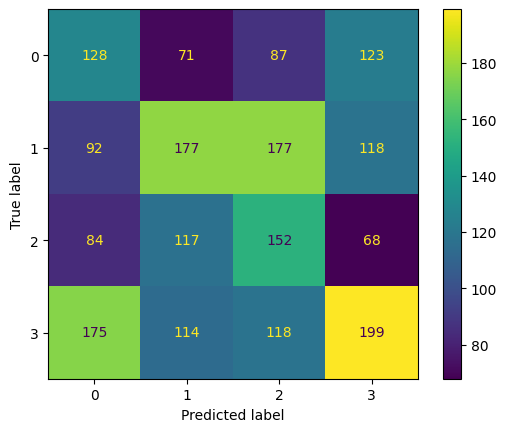

(2000,)


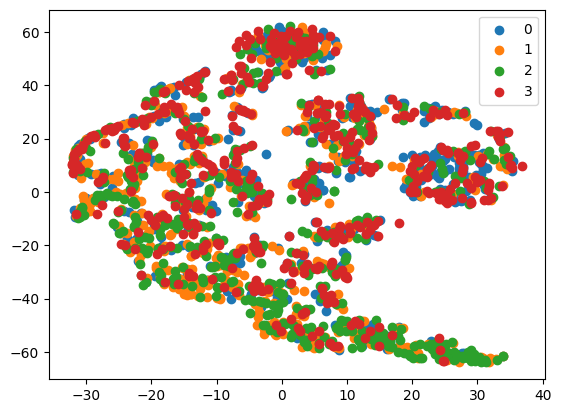

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
xtest_batched = torch.tensor(xtest);
xtest_batched = torch.split(xtest_batched, 25);
embeddings = [];
for batch in tqdm(xtest_batched):
    batch = batch.to("cuda:0")
    embeddings.append(model(batch).detach().cpu().float().numpy())
embeddings = np.stack(embeddings).reshape((-1, embeddings[0].shape[1]));
preds = torch.nn.functional.softmax(torch.tensor(embeddings), dim = -1);
preds = torch.argmax(preds, dim = -1);
#print(embeddings.shape)
SNE_embedds = TSNE(n_components=2, learning_rate='auto', init = 'random').fit_transform(embeddings)

ysamples = np.argmax(ytest, axis=1);


score = accuracy_score(preds.numpy(), ysamples)
print("accuracy score:", score);

cm = confusion_matrix(preds.numpy(), ysamples)
ConfusionMatrixDisplay(cm).plot();
plt.show()

fig, ax = plt.subplots()
print(ysamples.shape)
yclasses = np.unique(ysamples);
for y_class in yclasses:
    class_index = (ysamples == y_class).flatten();
    embedds = SNE_embedds[class_index];
    ax.scatter(embedds[:, 0], embedds[:, 1], label = y_class);
ax.legend();
plt.show();

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

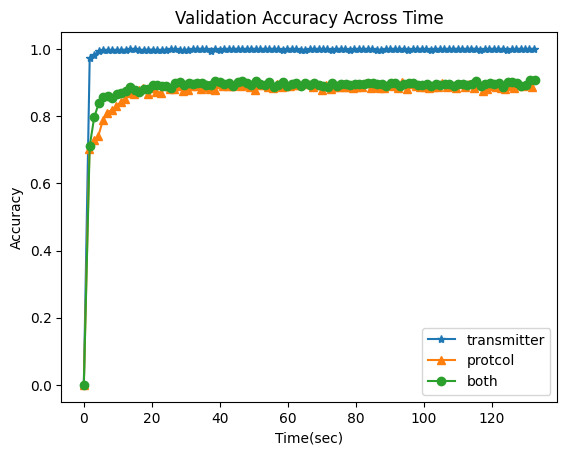

In [11]:
#visualize training time 
import json
import matplotlib.pyplot as plt

train_history_path  = "./results_transmitter/train_history.json";
with open(train_history_path, "r") as f:
    train_history = json.load(f);
time = [0];
val_acc = [0];
for epoch in train_history.keys():
    time.append(train_history[epoch]['time'])
    val_acc.append(train_history[epoch]["val_acc"]);
plt.plot(time, val_acc, marker = "*", label = "transmitter");

train_history_path  = "./results_protocol/train_history.json";
with open(train_history_path, "r") as f:
    train_history = json.load(f);
time = [0];
val_acc = [0];
for epoch in train_history.keys():
    time.append(train_history[epoch]['time'])
    val_acc.append(train_history[epoch]["val_acc"]);
plt.plot(time, val_acc, marker = "^", label = "protcol");

train_history_path  = "./results_both/train_history.json";
with open(train_history_path, "r") as f:
    train_history = json.load(f);
time = [0];
val_acc = [0];
for epoch in train_history.keys():
    time.append(train_history[epoch]['time'])
    val_acc.append(train_history[epoch]["val_acc"]);
plt.plot(time, val_acc, marker = "o", label = "both");

plt.title("Validation Accuracy Across Time")
plt.xlabel("Time(sec)")
plt.ylabel("Accuracy")
plt.legend();
plt.savefig("val_time_results.png")
plt.show();
